In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [7]:
G = FullyConnected([prior_size, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [8]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [9]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [10]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z))
        true_pred = D(data)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z))
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [11]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z))
            true_pred = D(data)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.7028, D: 0.6846
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 0.9434, D: 0.4077
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.2159, D: 0.4967


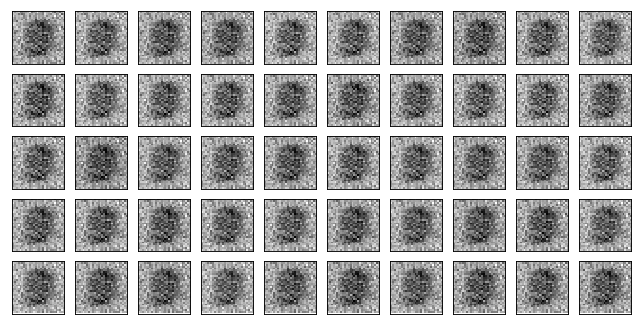

Test losses. G: 0.5983, D: 0.5010
Train Epoch: 2 [0/50000 (0%)]	Losses G: 0.9320, D: 0.5718
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 1.7967, D: 0.4190
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 2.5873, D: 0.3450


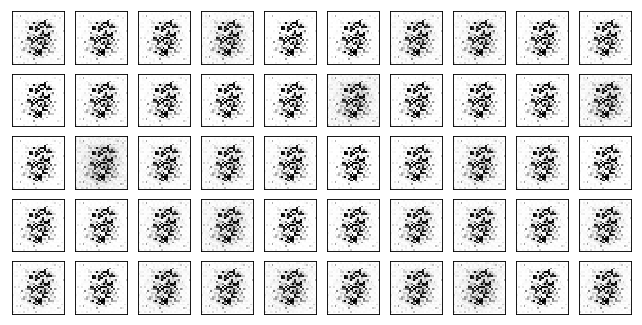

Test losses. G: 1.7292, D: 0.2170
Train Epoch: 3 [0/50000 (0%)]	Losses G: 2.8480, D: 0.2902
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 0.4095, D: 0.8560
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 1.2173, D: 0.6018


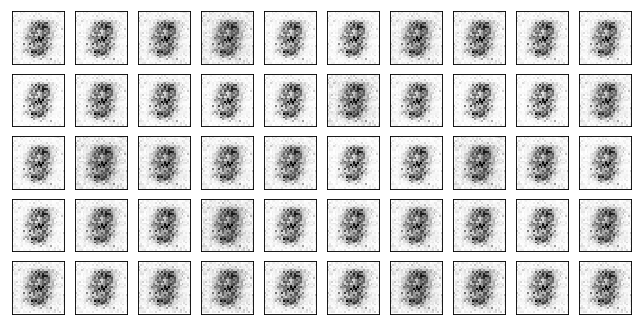

Test losses. G: 0.7753, D: 0.6374
Train Epoch: 4 [0/50000 (0%)]	Losses G: 1.1831, D: 0.6608
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 1.7486, D: 0.3541
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 0.7096, D: 0.6078


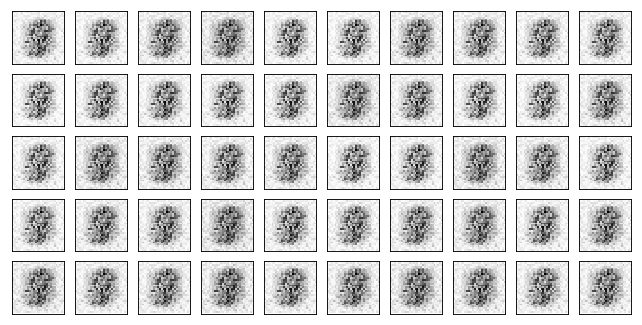

Test losses. G: 0.7063, D: 0.5970
Train Epoch: 5 [0/50000 (0%)]	Losses G: 0.7126, D: 0.5982
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 2.1671, D: 0.2865
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 1.7936, D: 0.4660


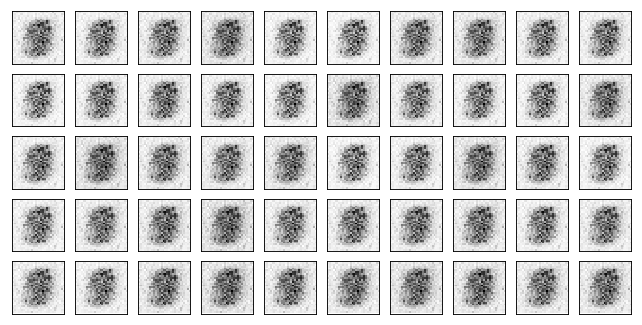

Test losses. G: 1.0668, D: 0.4521
Train Epoch: 6 [0/50000 (0%)]	Losses G: 1.7406, D: 0.5176
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 1.8565, D: 1.0592
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 0.9356, D: 0.6523


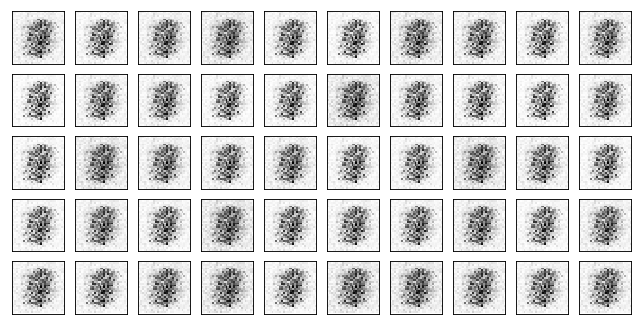

Test losses. G: 0.8167, D: 0.5835
Train Epoch: 7 [0/50000 (0%)]	Losses G: 0.9608, D: 0.6420
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 3.3157, D: 0.0782
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 1.9641, D: 0.3106


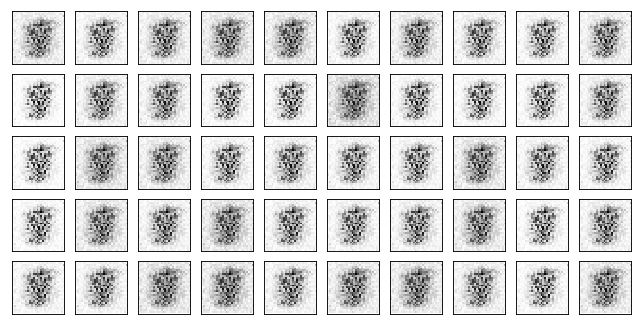

Test losses. G: 1.7323, D: 0.1873
Train Epoch: 8 [0/50000 (0%)]	Losses G: 1.9153, D: 0.3336
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 1.1975, D: 0.7161
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 5.2731, D: 0.0540


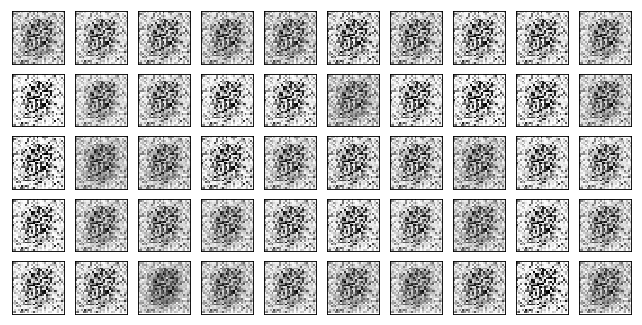

Test losses. G: 3.7166, D: 0.0301
Train Epoch: 9 [0/50000 (0%)]	Losses G: 4.8639, D: 0.0544
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 2.6884, D: 0.3127
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 2.4053, D: 0.2162


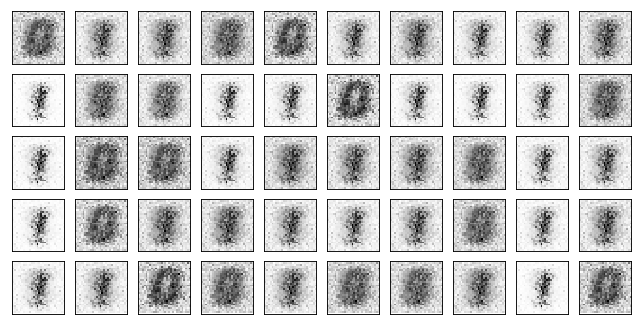

Test losses. G: 2.1562, D: 0.1248
Train Epoch: 10 [0/50000 (0%)]	Losses G: 2.3524, D: 0.2639
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 3.1606, D: 0.1566
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 3.4154, D: 0.1340


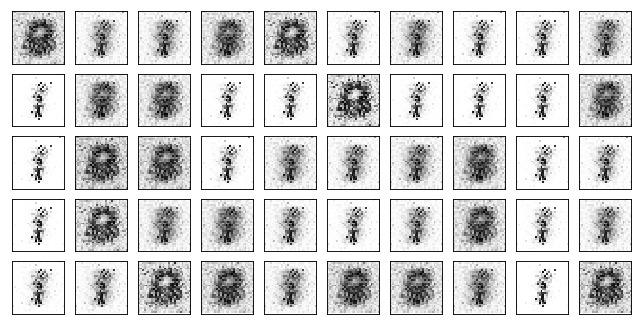

Test losses. G: 3.1467, D: 0.0499
Train Epoch: 11 [0/50000 (0%)]	Losses G: 3.2322, D: 0.1278
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 5.6539, D: 0.0692
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 4.7249, D: 0.4441


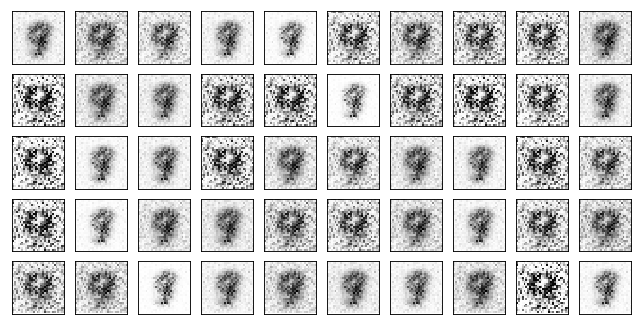

Test losses. G: 2.8737, D: 0.3181
Train Epoch: 12 [0/50000 (0%)]	Losses G: 3.4151, D: 0.5548
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 3.8462, D: 0.0996
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 4.2306, D: 0.0915


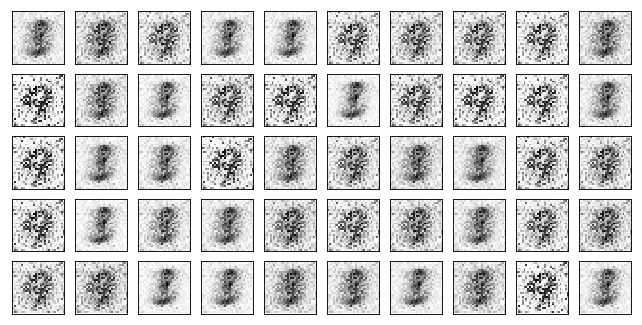

Test losses. G: 3.5534, D: 0.0340
Train Epoch: 13 [0/50000 (0%)]	Losses G: 4.1493, D: 0.0948
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 5.1422, D: 0.0895
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 4.4474, D: 0.2154


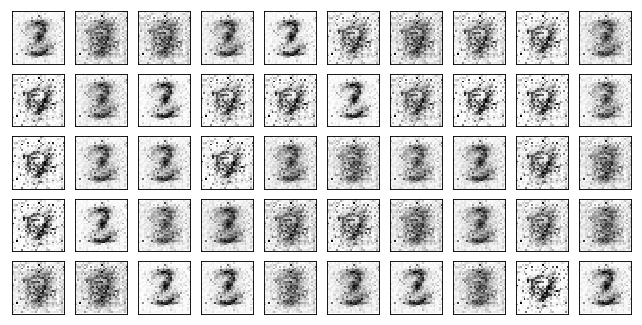

Test losses. G: 3.5778, D: 0.0595
Train Epoch: 14 [0/50000 (0%)]	Losses G: 3.9952, D: 0.1422
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 4.4667, D: 0.0663
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 4.5093, D: 0.0992


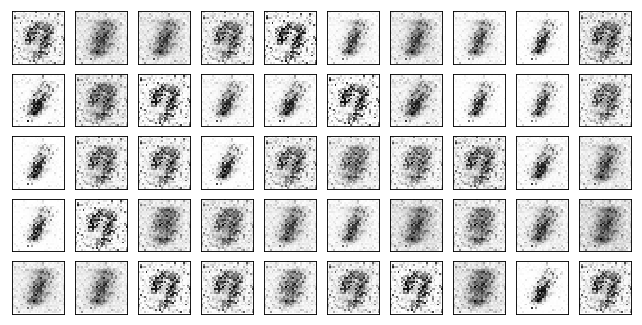

Test losses. G: 3.7038, D: 0.0479
Train Epoch: 15 [0/50000 (0%)]	Losses G: 4.5201, D: 0.0882
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 5.2991, D: 0.0549
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 6.1268, D: 0.1372


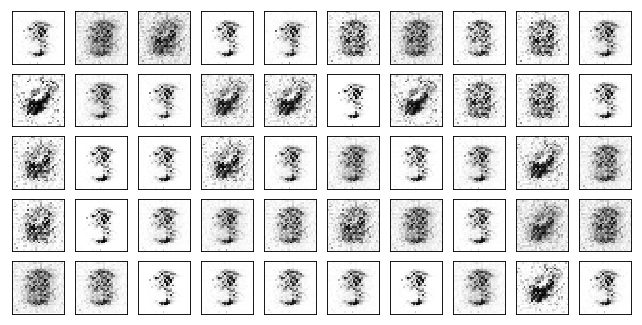

Test losses. G: 5.0965, D: 0.0437
Train Epoch: 16 [0/50000 (0%)]	Losses G: 5.6246, D: 0.1413
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 5.5741, D: 0.0759
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 5.5177, D: 0.0700


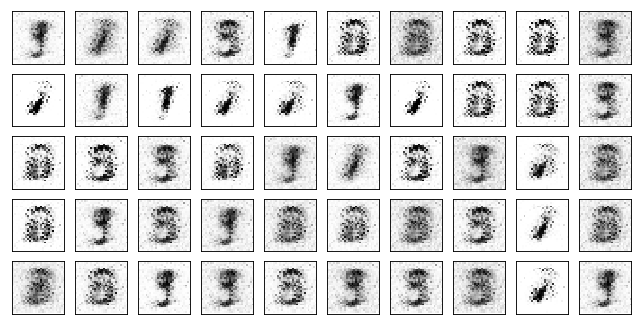

Test losses. G: 4.7809, D: 0.0131
Train Epoch: 17 [0/50000 (0%)]	Losses G: 5.3782, D: 0.0469
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 5.5020, D: 0.1214
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 6.1830, D: 0.1152


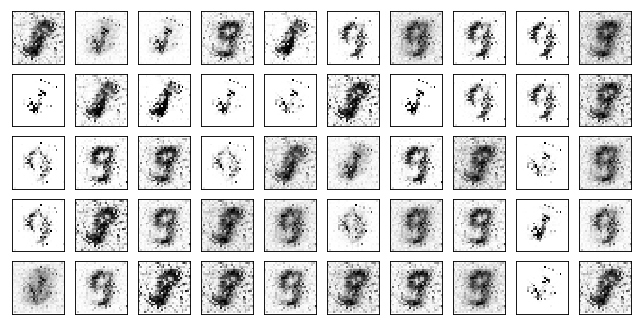

Test losses. G: 5.1585, D: 0.0366
Train Epoch: 18 [0/50000 (0%)]	Losses G: 5.6410, D: 0.1270
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 5.9748, D: 0.0703
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 4.2848, D: 0.1015


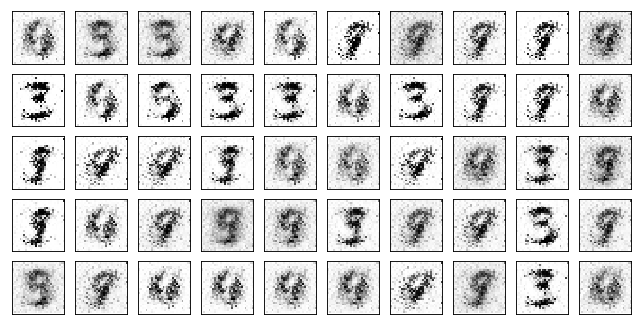

Test losses. G: 3.5066, D: 0.0383
Train Epoch: 19 [0/50000 (0%)]	Losses G: 4.6015, D: 0.1130
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 6.0291, D: 0.0611
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 4.3642, D: 0.0769


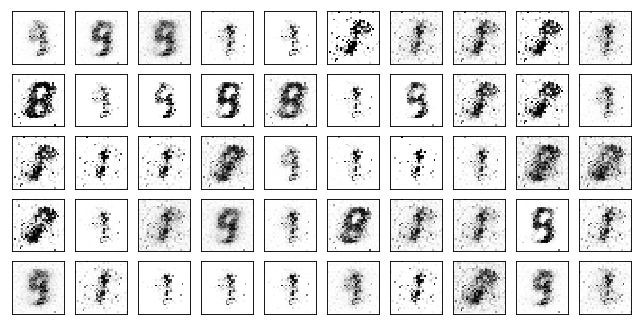

Test losses. G: 3.8868, D: 0.0220
Train Epoch: 20 [0/50000 (0%)]	Losses G: 3.8949, D: 0.0903
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 5.6562, D: 0.0647
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 5.0286, D: 0.0960


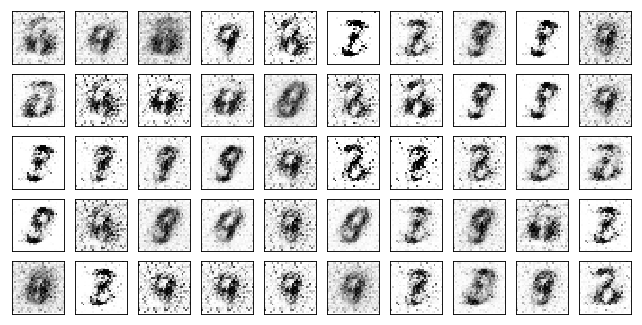

Test losses. G: 4.3782, D: 0.0257
Train Epoch: 21 [0/50000 (0%)]	Losses G: 5.1548, D: 0.0824
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 5.3961, D: 0.1619
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 5.2767, D: 0.0936


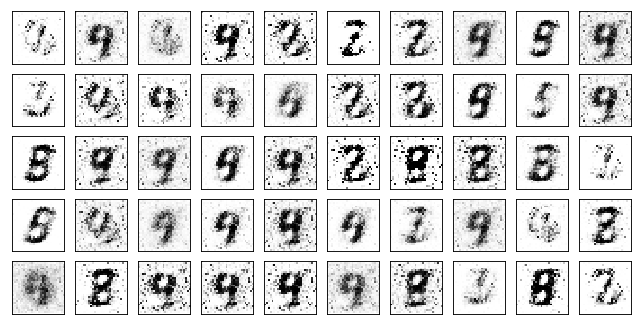

Test losses. G: 4.5455, D: 0.0385
Train Epoch: 22 [0/50000 (0%)]	Losses G: 5.8865, D: 0.0818
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 5.2426, D: 0.0746
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 4.5621, D: 0.0780


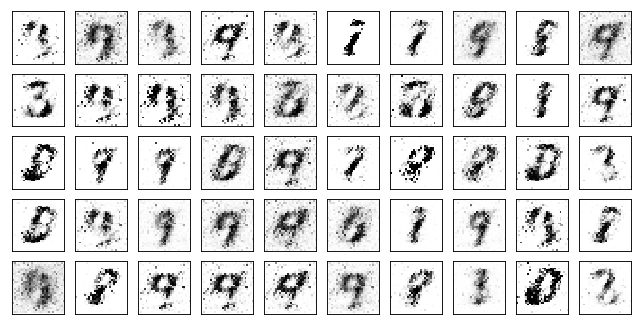

Test losses. G: 3.7753, D: 0.0293
Train Epoch: 23 [0/50000 (0%)]	Losses G: 4.2807, D: 0.0785
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 5.3514, D: 0.0777
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 4.8452, D: 0.1136


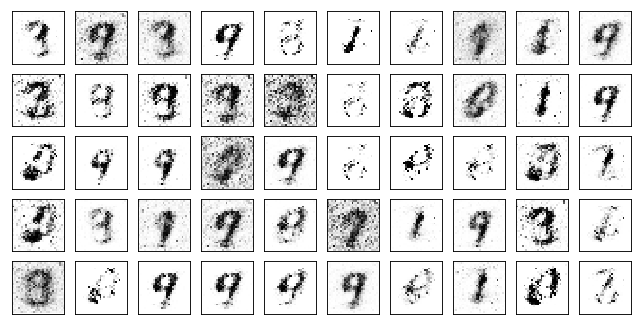

Test losses. G: 3.7060, D: 0.0358
Train Epoch: 24 [0/50000 (0%)]	Losses G: 5.8215, D: 0.0856
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 5.2412, D: 0.1219
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 5.1162, D: 0.0699


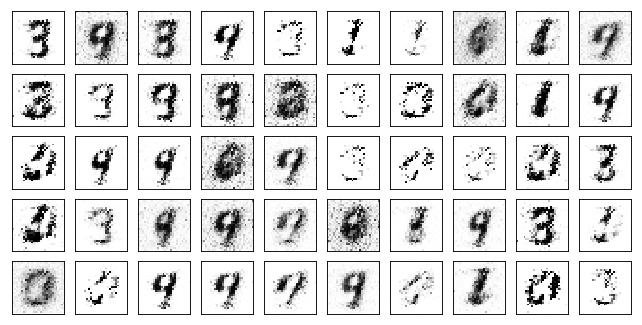

Test losses. G: 4.6187, D: 0.0232
Train Epoch: 25 [0/50000 (0%)]	Losses G: 5.7787, D: 0.0888
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 5.5946, D: 0.1077
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 3.6629, D: 0.1354


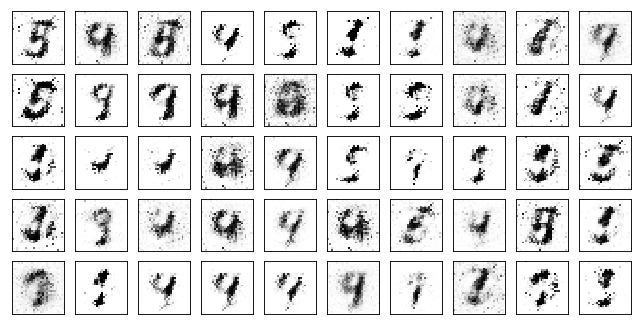

Test losses. G: 3.2261, D: 0.0775
Train Epoch: 26 [0/50000 (0%)]	Losses G: 4.5844, D: 0.1622
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 4.5838, D: 0.1475
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 4.2502, D: 0.1365


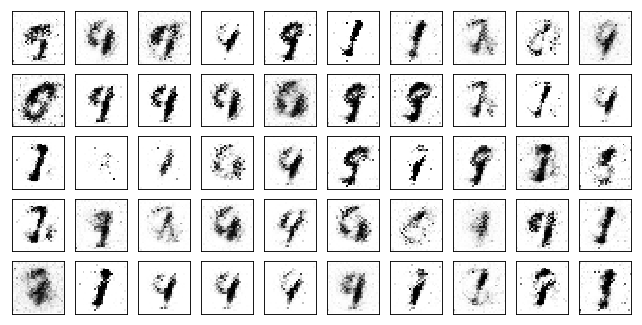

Test losses. G: 3.6118, D: 0.0450
Train Epoch: 27 [0/50000 (0%)]	Losses G: 4.2252, D: 0.1393
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 5.1069, D: 0.1250
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 5.0899, D: 0.1337


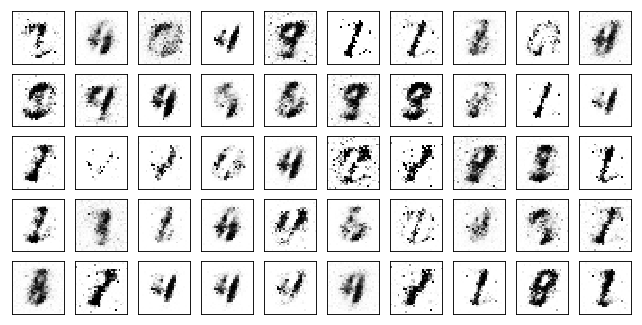

Test losses. G: 4.5529, D: 0.0446
Train Epoch: 28 [0/50000 (0%)]	Losses G: 5.1632, D: 0.1470
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 5.6600, D: 0.0967
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 5.5340, D: 0.1160


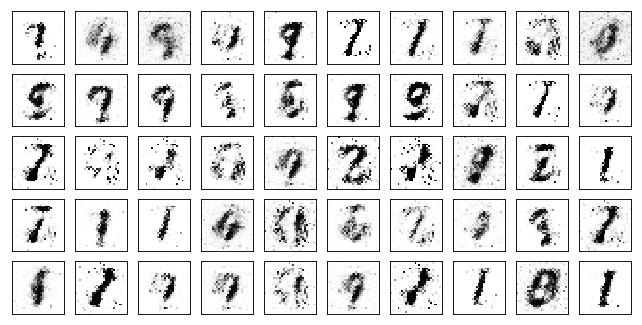

Test losses. G: 4.9170, D: 0.0365
Train Epoch: 29 [0/50000 (0%)]	Losses G: 4.8617, D: 0.0735
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 3.9075, D: 0.1441
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 4.3091, D: 0.1296


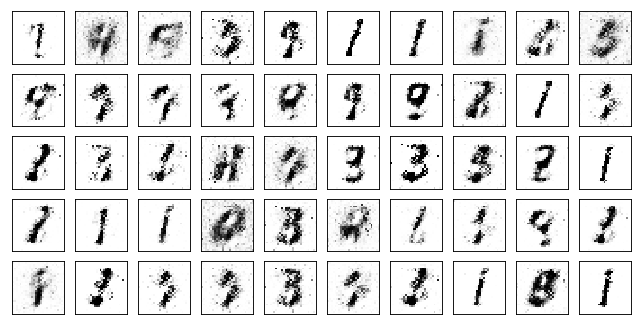

Test losses. G: 3.5972, D: 0.0570
Train Epoch: 30 [0/50000 (0%)]	Losses G: 4.2838, D: 0.1299
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 3.5049, D: 0.1400
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 4.1709, D: 0.1268


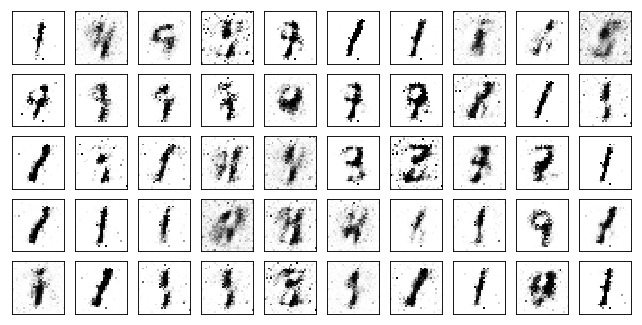

Test losses. G: 3.8417, D: 0.0522


In [12]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)